<div> 
 <div align="left"> <img src="JO_LOGO.gif" width="500" height="500" align="left">  </div>
 <div> <h1> <br/> <br/> <br/> <br/> Project: Mon Reader </h1> </div>
</div>

------------------------------------------------------------------------------
------------------------------------------------------------------------------

<div align="left"> <img src="ProjectOverview.jpeg" width="200" height="200" align="left"> </div>
<div> <p align="right"> <h3> <br><br><br><br>Project Overview </h3> </p> </div>

The main objective of the startup is to build a new mobile document digitization experience for the blind. The problem to be solved in this project is to identify if book images contain flipped pages or not. The company intends to use these labeled images as input for another machine learning model. 
This project's goal is to build a machine learning model that can label the book images as 'flip' or 'not flip'.

----------------------------------------------------------------------------------------------

<div> 
    <div align="left"><img src="data.png" width="50" height="50" align="left">
    </div>
    <div >
        <p align="left"><h4><br>Data source Overview</h4> </p>
    </div>
</div>

The data belongs to an organization which develops innovative Artificial Intelligence and Computer Vision solutions. The data provided contains images labelled as 'flip' and 'not flip'. The dataset contains 

|  | Dataset type  | Total Records #    | Flip count #   | Not flip count # | 
|---|---|---|---|---|
| 1 | Train Dataset  | 2392       | 1162   | 1230     |
| 2 | Test Dataset  | 597    | 290   | 307     |


----------------------------------------------------------------------------------------------

<html>
    <div align="left"><img src="config.gif" width="50" height="50" align="left">
    </div>
     <div align="left">
         <h3><br>Initial Setup </h3>
    </div>
</html>

 - <h5>Import all the required libraries</h5>

In [1]:
# Import the required Libraries
import os
import math
import random
import copy
import warnings
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from IPython.core.debugger import set_trace
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm import tqdm
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import shutil
from efficientnet_pytorch import EfficientNet


 - <h5>Set the random seed and image folder path</h5>

In [2]:
# Set the file path
data_train_path=os.path.join(os.path.abspath('') , "Data","images","training")
data_test_path=os.path.join(os.path.abspath('') , "Data","images","testing")
# Set the random seed
random_seed=121

# Set the random seed for python environment 
os.environ['PYTHONHASHSEED']=str(random_seed)

# Set numpy random seed
np.random.seed(random_seed)

# Set the random seed value
random.seed(random_seed)

# set the torch and cuda random seed
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)


# Setup List for storing the classfier, accuracy, f1 score and datatset type
eval_report=list()
# Filter out the warnings
warnings.filterwarnings('ignore')

In [3]:
# set computation device to cuda after checking it's available
_DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {_DEVICE}")
_DEVICE_2 = 'cpu'

# Bath sizes 
_BATCH_SIZE = 1

# Clear the cuda cache
torch.cuda.empty_cache()

Computation device: cuda:0


 - <h5> Define functions </h5>

In [4]:
# function 1
def visualize_images_DS (img_Ds, cols=3, rows=1):
    ''' visualize_images_DS:
    Input: 
    This function takes torch.utils.data.Dataset object as input 
    lstSentences: torch.utils.data.Dataset of images 
    Output:
    This function displays three images randomly from dataset and 
    shows their size and lable info
    '''
    # Define the label mapping
    labels_map = {
        0: "Flip",
        1: "Not Flip"
    }

    # Define image size
    figure = plt.figure(figsize=(6, 6))

    # Capture the id's
    id_values = []
    for i in range(1, cols * rows + 1):
        # Randomly select the id's
        sample_idx = torch.randint(len(img_Ds), size=(1,)).item()
        # Fetch image and label for random id
        img, label = img_Ds[sample_idx]
        #set_trace()
        # Alter the image shape 
        if img.shape[0] == 3:
            img1 = img.squeeze().permute(1,2,0)
        else:
            img1 = img.squeeze()
        # print(img1.shape)
        # add the subplots
        figure.add_subplot(rows, cols, i)
        # Set tittle
        plt.title(labels_map[label])
        plt.axis("off")
        id_values.append(sample_idx)
        # Show image
        plt.imshow(img1)
        
    # Show the image
    plt.show()
    # return the Id values 
    return id_values

# function 2
def temp_folder_setup(strDirPaths):
    ''' temp_folder_setup:
    Input: 
    This function takes directory path as input 
    strDirPaths: directory path
    Output:
    Directory structure for train and validation
    images shuffle
    '''
    
    # set the directory
    dir_temp = Path(strDirPaths[0])

    # If temporary directory exists clean it
    if dir_temp.is_dir():
        # Remove the directories
        shutil.rmtree(strDirPaths[0])
        
    print("[info]:temp Directory cleanup done !!")

    # Create the directory structure
    for strpath in strDirPaths:
        # set the path
        dir_temp = Path(strpath)
        # create the directory
        print("Creating directory ",strpath )
        dir_temp.mkdir()
        
    print("[info]:temp Directory Setup completed !!")

# function 3    
def file_move(X_train, X_val, Y_train, Y_val, strDirPaths):
    ''' file_move:
    Input: 
    This function takes directory path, train and validation 
    train & validation image paths as input 
    strDirPaths: directory path
    X_train: Train split images  
    X_val:  Validation split images  
    Y_train: Label for Train images 
    Y_val: Label for validation images 
    
    Output:
    Directory structure for train and validation
    images shuffle
    '''
    # Copy images into training folders
    for i, j in zip( X_train, Y_train):
        if j == 0 :
            shutil.copy(i, strDirPaths[5])
        else:
            shutil.copy(i, strDirPaths[6])
            
    print("[info]:temp training images copied !!")
    
    # Copy images into validation folders
    for i, j in zip( X_val, Y_val):
        if j == 0 :
            shutil.copy(i, strDirPaths[2])
        else:
            shutil.copy(i, strDirPaths[3]  ) 
            
    print("[info]:temp validation images copied !!")

# function 4    
def binary_acc(y_pred, y_test):
    ''' binary_acc:
    Input: 
    This function takes predicted image labels 
    and actual image labels 
    y_pred: Predicted image labels 
    y_test: Actual image labels 
    
    Output:
    Accuracy of images predicted 
    '''    
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tags
    
# function 5    
def mean_std(img_loader):
    ''' mean_std:
    Input: 
    This function calculate image mean and 
    standard deviation
    img_loader: DataLoader object of test/train/validation
    images
    
    Output:
    Channel wise mean and standard deviation of images 
    '''
    img, lbl = next(iter(img_loader))
    # shape of images [b,c,w,h]
    mean, std = img.mean([0,2,3]), img.std([0,2,3])
    return mean, std    


 - <h5> Define Classes</h5>

In [5]:
# Class 1
class flipClassifier(nn.Module):
    ''' 
    flipClassifier
    Class for defining custom CNN network 
    for image label classification 
    ''' 
    
    def __init__(self):
        super(flipClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block
    
# Class 2
class efficient_net_7_Model(nn.Module):
    ''' 
    efficient_net_7_Model
    Class for defining efficient_net utilizing 
    the pretrained network
    '''     
    def __init__(self):
        super(efficient_net_7_Model, self).__init__()
        self.B7_model = EfficientNet.from_pretrained('efficientnet-b7')
        
        self.fc = nn.Sequential(
                  nn.Linear(in_features=1000, out_features=256), #1000 is the last out_features
                  nn.ReLU(), #ReLu to be the activation function
                  nn.Dropout(p=0.3),
                  nn.Linear(in_features=256, out_features=2))
        
    def forward(self, x):
        x = self.B7_model(x)
        return self.fc(x)


 - <h5> define image config</h5>

In [6]:
# Paths for temp directory setup
strDirPaths = ["Data/images/temp/","Data/images/temp/validation/" ,
           "Data/images/temp/validation/flip/", "Data/images/temp/validation/notflip/" ,
           "Data/images/temp/training/" ,"Data/images/temp/training/flip/", "Data/images/temp/training/notflip/"]


# Image transformers for custom CNN neural network  
CNN_transforms = {
    "training": transforms.Compose([
        transforms.CenterCrop(1080),  
        transforms.Resize((224, 224)),                          
        transforms.ToTensor()
    ]),
    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()]),
    
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
}



 - <h5> Load the images data</h5>

In [7]:
print("Loading Test images !! ")

# Load the test data 
image_test_ds = datasets.ImageFolder(data_test_path, CNN_transforms['test'])  

# Fetch the labels 
y_labels = [ image_test_ds.imgs[item][1] for item in range(len(image_test_ds)) ]
# Batch load the test images  
test_loader = torch.utils.data.DataLoader(image_test_ds, 
                                          batch_size=_BATCH_SIZE, 
                                          shuffle=True,
                                         num_workers=1)

print("Loading Training & Validation images !! ")

# Do the temporary folder setup
temp_folder_setup(strDirPaths)

# Load the test data 
image_train_ds = datasets.ImageFolder(data_train_path)  

# Fetch image paths and labels
X = [ image_train_ds.imgs[item][0] for item in range(len(image_train_ds)) ]
Y = [ image_train_ds.imgs[item][1] for item in range(len(image_train_ds)) ]

# Do train and validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y , test_size = 0.1, random_state = random_seed)

# Create temporary training and validation images folder
file_move(X_train, X_val, Y_train, Y_val, strDirPaths)

# load the image folders 
fld_image_train = datasets.ImageFolder(strDirPaths[4], CNN_transforms['training']) 
fld_image_val = datasets.ImageFolder(strDirPaths[1], CNN_transforms['valid']) 

# load the training and validation image folders into batch loaders
batch_train_loader = DataLoader(dataset=fld_image_train, shuffle=True, batch_size=8)
batch_val_loader = DataLoader(dataset=fld_image_val, shuffle=True, batch_size=1)

Loading Test images !! 
Loading Training & Validation images !! 
[info]:temp Directory cleanup done !!
Creating directory  Data/images/temp/
Creating directory  Data/images/temp/validation/
Creating directory  Data/images/temp/validation/flip/
Creating directory  Data/images/temp/validation/notflip/
Creating directory  Data/images/temp/training/
Creating directory  Data/images/temp/training/flip/
Creating directory  Data/images/temp/training/notflip/
[info]:temp Directory Setup completed !!
[info]:temp training images copied !!
[info]:temp validation images copied !!


----------------------------------------------------------------------------------------------

<div> 
    <div align="left">
        <img src="EDA.jpeg" width="250" height="250"  align="left">
    </div>
    <div>
        <p align="right"><h3><br><br><br><br>Exploratory Data Analysis</h3></p>
    </div>
</div>

 - Check for label distributions in Test and Train distribution

In [8]:
# Data 
data = {'Train': [ len(fld_image_train) + len(fld_image_val) , 
                  len(fld_image_train) + len(fld_image_val) - np.sum(Y_train) - np.sum(Y_val),
                  np.sum(Y_train) + np.sum(Y_val)
                 ],
        'Test': [ len(y_labels), len(y_labels) - np.sum(y_labels), np.sum(y_labels) ] }
# Check for image shapes 
df_images = pd.DataFrame(data) 
df_images.index = ['Total_Count','Flip_Img_Count','Not_Flip_Img_Count' ]

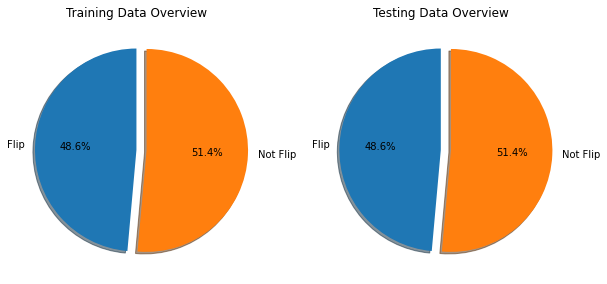

In [9]:
# Define Labels and explode
labels = ['Flip', 'Not Flip']
explode = (0, 0.1)

# Plot the pie charts 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
# Pie chart for Train dataset image distribution
ax1.pie(df_images['Train'][1:], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode)
ax1.set_title('Training Data Overview')
# Pie chart for Test dataset image distribution
ax2.pie(df_images['Test'][1:], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode)
ax2.set_title('Testing Data Overview')
# show the plot
plt.show()

From looking at the label distirbution, train and test dataset both almost uniform distribtution of labels.

 - Check for image size and visualize

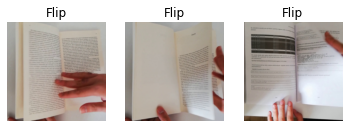

In [10]:
# Visualize Training images
lst_val = visualize_images_DS (fld_image_train,cols=3, rows=1)

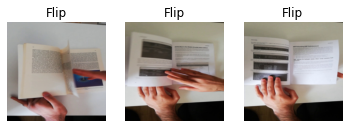

In [11]:
# Visualize validation images
lst_val = visualize_images_DS (fld_image_val,cols=3, rows=1)

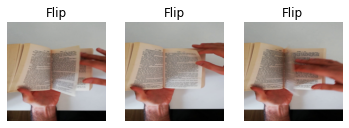

In [12]:
# Visualize test images
lst_val = visualize_images_DS( image_test_ds, cols=3, rows=1)

<ul>
    <p>Following are the observations from visualizing the images :</p>
    <ul style="list-style-type:square;">
        <li> The images are off focus.</li>
        <li>The images are not square shaped, which is required by neural network.</li> 
        <li>There is a lot of noise in the images.</li>
    </ul>
</ul>

## Custom CNN Classifier 
A custom CNN network for classifying images are flip or not flip labels. 

##### Step1: Initialize the model and initialize config parameters
Create a class instance and initialize the model configurational parameters like optimizers to be used, learning rate.

In [13]:
# initialize the model 
model_flipCls = flipClassifier()

#Defining the model hyper parameters
num_epochs = 25
learning_rate = 0.001

# loss criterion 
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model_flipCls.parameters(), lr=learning_rate )

dict_train_val_metrics_cstm = {
    'epoch_train_loss': [],
    'epoch_train_accuracy': [],
    'epoch_val_loss': [],
    'epoch_val_accuracy': [],
    # best performance 
    '_best_accu': 0.0
} 

##### Step 2: Train the neural network
Train the model and test it on validation dataset. 

In [14]:
# start the training loop 
for epoch in tqdm(range(1, num_epochs)):
    
    # Start the timer start.record()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    
    #Training process begins
    train_loss_list = 0
    train_acc_list = 0
   
    print("[Info]!! Model in training mode")
    
    # move Device to GPU
    model_flipCls = model_flipCls.to(_DEVICE)
    
    #Iterating over the training dataset in batches
    model_flipCls.train()
    
    # Enumerate the batches 
    for images, labels in batch_train_loader:
        
        #Extracting images and target labels for the batch being iterated
        images, labels = images.to(_DEVICE), labels.to(_DEVICE)

        # zero the gradients
        optimizer.zero_grad()

        #Calculating the model output and the cross entropy loss
        label_predicted = model_flipCls(images).squeeze() 
        train_loss  = criterion(label_predicted, labels)
        train_acc, _ = binary_acc(label_predicted, labels)
        train_loss.backward()
        optimizer.step()
        train_loss_list += train_loss.item()
        train_acc_list += train_acc.item()
        
     # VALIDATION
    with torch.no_grad():
        model_flipCls.to(_DEVICE_2)
        model_flipCls.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for images_val, labels_val in  batch_val_loader:
            images_val, labels_val = images_val, labels_val
            y_val_pred = model_flipCls(images_val).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, labels_val)
            val_acc, _ = binary_acc(y_val_pred, labels_val)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        
        dict_train_val_metrics_cstm['epoch_train_loss'].append(train_loss_list/len(batch_train_loader))
        dict_train_val_metrics_cstm['epoch_train_accuracy'].append(train_acc_list/len(batch_train_loader))
        # Append the validation accuracy and loss  epoch_val_loss
        dict_train_val_metrics_cstm['epoch_val_loss'].append(val_epoch_loss/len(batch_val_loader))
        dict_train_val_metrics_cstm['epoch_val_accuracy'].append(val_epoch_acc/len(batch_val_loader))
        
        if dict_train_val_metrics_cstm['epoch_val_accuracy'][-1] > dict_train_val_metrics_cstm['_best_accu']: 
            print("Saving the model best accuracy found at  epoch ",epoch)
            dict_train_val_metrics_cstm['_best_accu'] = dict_train_val_metrics_cstm['epoch_val_accuracy'][-1] 
            torch.save({
                'epoch': epoch,
                'model_state_dict': model_flipCls.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                },  'outputs/best_model_model_flipCls.pth')
 
        print(f"Epoch {epoch+0:02}:| Train Loss: {dict_train_val_metrics_cstm['epoch_train_loss'][-1]} | Val Loss: {dict_train_val_metrics_cstm['epoch_val_loss'][-1]} | Train Acc: {dict_train_val_metrics_cstm['epoch_train_accuracy'][-1]} | Val Acc: {dict_train_val_metrics_cstm['epoch_val_accuracy'][-1]}")


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/25: [Info]!! Model in training mode


  4%|▍         | 1/24 [07:25<2:50:53, 445.82s/it]

Saving the model best accuracy found at  epoch  1
Epoch 01:| Train Loss: 6.208601074251534 | Val Loss: 36.22364016789822 | Train Acc: 82.93308550185874 | Val Acc: 67.91666666666667
Epoch 3/25: [Info]!! Model in training mode


  8%|▊         | 2/24 [14:27<2:38:17, 431.71s/it]

Epoch 02:| Train Loss: 4.021989383948111 | Val Loss: 25.551581713047927 | Train Acc: 89.54646840148699 | Val Acc: 60.416666666666664
Epoch 4/25: [Info]!! Model in training mode


 12%|█▎        | 3/24 [21:23<2:28:34, 424.52s/it]

Epoch 03:| Train Loss: 1.8115721977574164 | Val Loss: 33.50756454136938 | Train Acc: 94.22304832713755 | Val Acc: 63.75
Epoch 5/25: [Info]!! Model in training mode


 17%|█▋        | 4/24 [31:47<2:47:42, 503.13s/it]

Saving the model best accuracy found at  epoch  4
Epoch 04:| Train Loss: 1.6800244400249276 | Val Loss: 18.164281073999415 | Train Acc: 95.43122676579925 | Val Acc: 69.58333333333333
Epoch 6/25: [Info]!! Model in training mode


 21%|██        | 5/24 [38:32<2:28:09, 467.85s/it]

Epoch 05:| Train Loss: 1.3810613472371287 | Val Loss: 49.14273768070292 | Train Acc: 96.1003717472119 | Val Acc: 67.5
Epoch 7/25: [Info]!! Model in training mode


 25%|██▌       | 6/24 [41:34<1:51:13, 370.75s/it]

Epoch 06:| Train Loss: 1.1560899655276349 | Val Loss: 44.546851377939035 | Train Acc: 96.60223048327137 | Val Acc: 66.66666666666667
Epoch 8/25: [Info]!! Model in training mode


 29%|██▉       | 7/24 [44:37<1:27:38, 309.31s/it]

Epoch 07:| Train Loss: 1.0197434218243744 | Val Loss: 26.23391851579029 | Train Acc: 96.47583643122677 | Val Acc: 69.58333333333333
Epoch 9/25: [Info]!! Model in training mode


 33%|███▎      | 8/24 [47:42<1:11:55, 269.70s/it]

Epoch 08:| Train Loss: 0.7064749431704076 | Val Loss: 32.84272734014969 | Train Acc: 97.56133828996282 | Val Acc: 62.083333333333336
Epoch 10/25: [Info]!! Model in training mode


 38%|███▊      | 9/24 [50:44<1:00:35, 242.36s/it]

Epoch 09:| Train Loss: 0.5978716383056987 | Val Loss: 21.62442811342981 | Train Acc: 97.7918215613383 | Val Acc: 68.75
Epoch 11/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  10


 42%|████▏     | 10/24 [53:43<51:56, 222.63s/it] 

Epoch 10:| Train Loss: 0.7059350520063561 | Val Loss: 21.021310706152228 | Train Acc: 97.55762081784387 | Val Acc: 70.83333333333333
Epoch 12/25: [Info]!! Model in training mode


 46%|████▌     | 11/24 [56:35<44:51, 207.08s/it]

Epoch 11:| Train Loss: 0.6756268330108318 | Val Loss: 27.303158818775167 | Train Acc: 97.37918215613382 | Val Acc: 66.66666666666667
Epoch 13/25: [Info]!! Model in training mode


 50%|█████     | 12/24 [59:25<39:09, 195.80s/it]

Saving the model best accuracy found at  epoch  12
Epoch 12:| Train Loss: 1.1200399836836845 | Val Loss: 23.765513405572772 | Train Acc: 97.09665427509293 | Val Acc: 71.66666666666667
Epoch 14/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  13


 54%|█████▍    | 13/24 [1:02:15<34:30, 188.23s/it]

Epoch 13:| Train Loss: 0.5045778771799337 | Val Loss: 16.706555006488546 | Train Acc: 98.36059479553903 | Val Acc: 76.66666666666667
Epoch 15/25: [Info]!! Model in training mode


 58%|█████▊    | 14/24 [1:05:06<30:28, 182.81s/it]

Epoch 14:| Train Loss: 0.2848544251847452 | Val Loss: 18.981474581304262 | Train Acc: 98.7918215613383 | Val Acc: 75.0
Epoch 16/25: [Info]!! Model in training mode


 62%|██████▎   | 15/24 [1:07:58<26:57, 179.67s/it]

Epoch 15:| Train Loss: 0.2892743715364084 | Val Loss: 23.07209632605507 | Train Acc: 98.96282527881041 | Val Acc: 65.83333333333333
Epoch 17/25: [Info]!! Model in training mode


 67%|██████▋   | 16/24 [1:10:48<23:34, 176.86s/it]

Epoch 16:| Train Loss: 0.4305868120065806 | Val Loss: 22.297573163240603 | Train Acc: 98.43494423791822 | Val Acc: 72.5
Epoch 18/25: [Info]!! Model in training mode


 71%|███████   | 17/24 [1:13:39<20:24, 174.97s/it]

Epoch 17:| Train Loss: 0.3107876560489546 | Val Loss: 27.558512466274767 | Train Acc: 98.74349442379182 | Val Acc: 64.16666666666667
Epoch 19/25: [Info]!! Model in training mode


 75%|███████▌  | 18/24 [1:16:31<17:24, 174.09s/it]

Epoch 18:| Train Loss: 0.1916369224635031 | Val Loss: 52.282670313558505 | Train Acc: 98.74349442379182 | Val Acc: 60.0
Epoch 20/25: [Info]!! Model in training mode


 79%|███████▉  | 19/24 [1:19:21<14:25, 173.02s/it]

Epoch 19:| Train Loss: 0.26486116390380293 | Val Loss: 34.75978623090655 | Train Acc: 99.10780669144981 | Val Acc: 67.5
Epoch 21/25: [Info]!! Model in training mode


 83%|████████▎ | 20/24 [1:22:12<11:28, 172.23s/it]

Epoch 20:| Train Loss: 0.10905004853452752 | Val Loss: 19.766108941393398 | Train Acc: 99.1003717472119 | Val Acc: 75.41666666666667
Epoch 22/25: [Info]!! Model in training mode


 88%|████████▊ | 21/24 [1:25:03<08:35, 171.81s/it]

Epoch 21:| Train Loss: 0.4142957525663531 | Val Loss: 29.48539872178369 | Train Acc: 98.61338289962825 | Val Acc: 61.666666666666664
Epoch 23/25: [Info]!! Model in training mode


 92%|█████████▏| 22/24 [1:27:52<05:42, 171.13s/it]

Epoch 22:| Train Loss: 0.49930431964293437 | Val Loss: 30.629948072712306 | Train Acc: 98.3271375464684 | Val Acc: 65.0
Epoch 24/25: [Info]!! Model in training mode


 96%|█████████▌| 23/24 [1:30:43<02:50, 170.93s/it]

Epoch 23:| Train Loss: 0.14626583989676334 | Val Loss: 27.640019978608503 | Train Acc: 99.41263940520446 | Val Acc: 62.916666666666664
Epoch 25/25: [Info]!! Model in training mode


100%|██████████| 24/24 [1:33:34<00:00, 233.92s/it]

Epoch 24:| Train Loss: 0.26922587628794187 | Val Loss: 34.26248303507734 | Train Acc: 98.6914498141264 | Val Acc: 54.583333333333336


##### Step 3: Visualize the training process
Once training is completed loss and accuracy is plotted for both training and validation datasets to understand the tarining process.

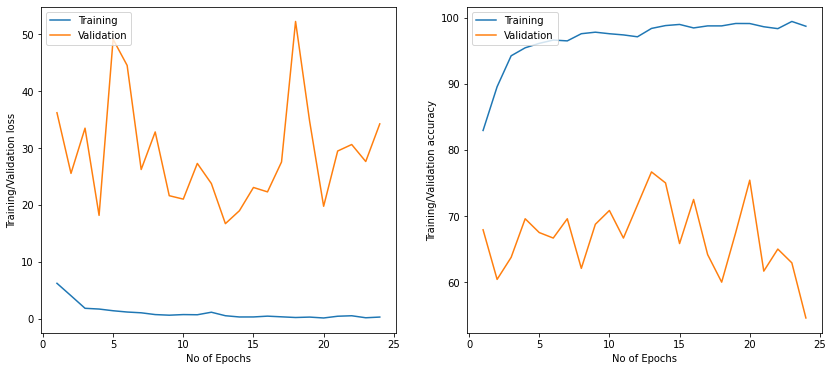

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].plot(range(1,len(dict_train_val_metrics_cstm['epoch_train_loss'])+1), dict_train_val_metrics_cstm['epoch_train_loss'], label="Training")
ax[0].plot(range(1,len(dict_train_val_metrics_cstm['epoch_val_loss'])+1), dict_train_val_metrics_cstm['epoch_val_loss'], label="Validation" )
ax[0].set_xlabel("No of Epochs")
ax[0].set_ylabel("Training/Validation loss")
ax[0].legend(loc="upper left") 
ax[1].plot(range(1,len(dict_train_val_metrics_cstm['epoch_train_accuracy'])+1), dict_train_val_metrics_cstm['epoch_train_accuracy'], label="Training" )
ax[1].plot(range(1,len(dict_train_val_metrics_cstm['epoch_val_accuracy'])+1), dict_train_val_metrics_cstm['epoch_val_accuracy'], label="Validation")
ax[1].set_xlabel("No of Epochs")
ax[1].set_ylabel("Training/Validation accuracy")
ax[1].legend(loc="upper left")

From the plot it seens the loss values for both datasets are almost simillar. From the plot the chances of overfitting are high.

##### Step 4: Evaluate the best model on test data
Load the best model trained and test it.

In [16]:
# Load the best model saved during the training process
best_model = flipClassifier()
checkpoint = torch.load("outputs/best_model_model_flipCls.pth")

# Load the state dict vlaues
best_model.load_state_dict(checkpoint['model_state_dict'])
### now you can evaluate it
best_model.eval()


labels_test = []
predicted_lbl_test = []
accuracy_lst = []

# Predict for Test Dataset 
for i, (images, labels) in enumerate(test_loader):
    
    # Predict the labels
    predicted_values = best_model(images)
    labels_test.extend(labels)
    # Calculate accuracy
    accuracy, pred_labels  = binary_acc(predicted_values, labels )
    accuracy = accuracy.item()
    predicted_lbl_test.extend(pred_labels)

    accuracy_lst.append(accuracy)
    
print( "Accuracy on Test Dataset ", np.round(np.average(accuracy_lst), 3))
print(classification_report(labels_test, [ lbl.item() for lbl in predicted_lbl_test ]))

Accuracy on Test Dataset  76.549
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       290
           1       0.74      0.83      0.78       307

    accuracy                           0.77       597
   macro avg       0.77      0.76      0.76       597
weighted avg       0.77      0.77      0.76       597



The performance of the model on Test images look ok. We are able to predict the labels of  with an accuracy of 74.7%. 

## EfficientNet transfer learning 
EfficientNet is a state of the art image classification neural network. The implementation done for the project is transfer learning for pre-trained layers of the model. 

##### Step1: Image Loading and Transformation
Load the images with application of transformers to transform the images. 

In [23]:
import copy
#calculate mean and std of validation an training batches
mean_train, std_train = mean_std(batch_train_loader)
mean_val, std_val = mean_std(batch_val_loader)

# Image transformers for efficient_net_7_Model 
effNet_transforms = {
    'training': transforms.Compose([
        transforms.CenterCrop(1080),  
        transforms.Resize(224),                                              
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_train, std=std_train)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224), 
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_val, std=std_val)
    ])
}

# load the image folders 
effNet_image_train = datasets.ImageFolder(strDirPaths[4], effNet_transforms['training']) 
effNet_image_val = datasets.ImageFolder(strDirPaths[1], effNet_transforms['valid']) 

# load the training and validation image folders into batch loaders
batch_train_effNetloader = DataLoader(dataset=effNet_image_train, shuffle=True, batch_size=8)
batch_val_effNetloader = DataLoader(dataset=effNet_image_val, shuffle=True, batch_size=1)

##### Step 2: Visualize the images 
Visualize the transformed images for EfficientNet neural network.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


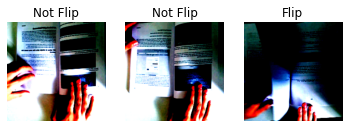

In [24]:
# Visualize Training images
lst_val = visualize_images_DS (effNet_image_train,cols=3, rows=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


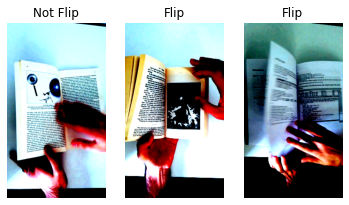

In [25]:
# Visualize validation images
lst_val = visualize_images_DS (effNet_image_val,cols=3, rows=1)

##### Step3: Initialize the EfficientNet model and initialize config parameters

In [26]:
# Define the model
eff_net_model_7 = efficient_net_7_Model()
#define criterion, optimzer and scheduler for our model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eff_net_model_7.parameters(), lr=0.001)

#define the epochs
num_epochs = 25

# define the metric 
train_val_metrics_effnet = {
    'epoch_train_loss': [],
    'epoch_train_accuracy': [],
    'epoch_val_loss': [],
    'epoch_val_accuracy': [],
    # best performance 
    '_best_accu': 0.0
} 

Loaded pretrained weights for efficientnet-b7


##### Step 4: Train the neural network
Train the model for 25 epochs and save the model with best accuracy on Test Dataset.

In [27]:
# start the training loop 
for epoch in tqdm(range(1, num_epochs)):
    
    # Start the timer start.record()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    
    #Training process begins
    train_loss_list = 0
    train_acc_list = 0
   
    print("[Info]!! Model in training mode")
    
    # move Device to GPU
    eff_net_model_7 = eff_net_model_7.to(_DEVICE)
    
    #Iterating over the training dataset in batches
    eff_net_model_7.train()
    
    # Enumerate the batches 
    for images, labels in batch_train_loader:
        
        #Extracting images and target labels for the batch being iterated
        images, labels = images.to(_DEVICE), labels.to(_DEVICE)

        # zero the gradients
        optimizer.zero_grad()

        #Calculating the model output and the cross entropy loss
        label_predicted = eff_net_model_7(images).squeeze() 
        train_loss  = criterion(label_predicted, labels)
        train_acc, _ = binary_acc(label_predicted, labels)
        train_loss.backward()
        optimizer.step()
        train_loss_list += train_loss.item()
        train_acc_list += train_acc.item()
        
     # VALIDATION
    with torch.no_grad():
        eff_net_model_7.to(_DEVICE_2)
        eff_net_model_7.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for images_val, labels_val in  batch_val_loader:
            images_val, labels_val = images_val, labels_val
            y_val_pred = eff_net_model_7(images_val).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, labels_val)
            val_acc, _ = binary_acc(y_val_pred, labels_val)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        
        train_val_metrics_effnet['epoch_train_loss'].append(train_loss_list/len(batch_train_loader))
        train_val_metrics_effnet['epoch_train_accuracy'].append(train_acc_list/len(batch_train_loader))
        # Append the validation accuracy and loss  epoch_val_loss
        train_val_metrics_effnet['epoch_val_loss'].append(val_epoch_loss/len(batch_val_loader))
        train_val_metrics_effnet['epoch_val_accuracy'].append(val_epoch_acc/len(batch_val_loader))
        
        if train_val_metrics_effnet['epoch_val_accuracy'][-1] > train_val_metrics_effnet['_best_accu']: 
            print("Saving the model best accuracy found at  epoch ",epoch)
            train_val_metrics_effnet['_best_accu'] = train_val_metrics_effnet['epoch_val_accuracy'][-1] 
            torch.save({
                'epoch': epoch,
                'model_state_dict': eff_net_model_7.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                },  'outputs/best_model_eff_net_model_7.pth')
 
        print(f"Epoch {epoch+0:02}:| Train Loss: {train_val_metrics_effnet['epoch_train_loss'][-1]} | Val Loss: {train_val_metrics_effnet['epoch_val_loss'][-1]} | Train Acc: {train_val_metrics_effnet['epoch_train_accuracy'][-1]} | Val Acc: {train_val_metrics_effnet['epoch_val_accuracy'][-1]}")


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  1


  4%|▍         | 1/24 [06:51<2:37:47, 411.63s/it]

Epoch 01:| Train Loss: 0.3904323518928833 | Val Loss: 1.6296925228331627 | Train Acc: 84.93680297397769 | Val Acc: 57.5
Epoch 3/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  2


  8%|▊         | 2/24 [13:43<2:31:04, 412.04s/it]

Epoch 02:| Train Loss: 0.23783304079162687 | Val Loss: 0.8730533948787188 | Train Acc: 92.27881040892193 | Val Acc: 72.91666666666667
Epoch 4/25: [Info]!! Model in training mode


 12%|█▎        | 3/24 [20:33<2:23:44, 410.69s/it]

Epoch 03:| Train Loss: 0.1664781602506667 | Val Loss: 0.8260108884905283 | Train Acc: 95.46840148698885 | Val Acc: 65.83333333333333
Epoch 5/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  4


 17%|█▋        | 4/24 [27:17<2:16:04, 408.23s/it]

Epoch 04:| Train Loss: 0.08731816027856266 | Val Loss: 0.5210155304504515 | Train Acc: 97.23048327137546 | Val Acc: 86.66666666666667
Epoch 6/25: [Info]!! Model in training mode


 21%|██        | 5/24 [33:56<2:08:14, 404.96s/it]

Epoch 05:| Train Loss: 0.08081304056004068 | Val Loss: 2.2451893151826336 | Train Acc: 97.86988847583643 | Val Acc: 77.91666666666667
Epoch 7/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  6


 25%|██▌       | 6/24 [40:17<1:59:04, 396.91s/it]

Epoch 06:| Train Loss: 0.1629814275890692 | Val Loss: 0.1885560072144558 | Train Acc: 95.94423791821562 | Val Acc: 93.33333333333333
Epoch 8/25: [Info]!! Model in training mode


 29%|██▉       | 7/24 [46:36<1:50:46, 390.99s/it]

Epoch 07:| Train Loss: 0.2912632972855028 | Val Loss: 0.26263616783399574 | Train Acc: 90.62453531598513 | Val Acc: 93.33333333333333
Epoch 9/25: [Info]!! Model in training mode


 33%|███▎      | 8/24 [52:54<1:43:07, 386.69s/it]

Epoch 08:| Train Loss: 0.12563371315420674 | Val Loss: 0.6353349756424147 | Train Acc: 97.20074349442379 | Val Acc: 82.5
Epoch 10/25: [Info]!! Model in training mode


 38%|███▊      | 9/24 [59:09<1:35:46, 383.07s/it]

Epoch 09:| Train Loss: 0.0492316001382445 | Val Loss: 0.18433181409617558 | Train Acc: 98.46840148698885 | Val Acc: 92.08333333333333
Epoch 11/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  10


 42%|████▏     | 10/24 [1:05:25<1:28:55, 381.09s/it]

Epoch 10:| Train Loss: 0.019709084321800484 | Val Loss: 0.17193495894205954 | Train Acc: 99.37546468401487 | Val Acc: 97.08333333333333
Epoch 12/25: [Info]!! Model in training mode


 46%|████▌     | 11/24 [1:11:40<1:22:08, 379.08s/it]

Epoch 11:| Train Loss: 0.03250581334783014 | Val Loss: 0.15574045734827116 | Train Acc: 99.19330855018588 | Val Acc: 96.25
Epoch 13/25: [Info]!! Model in training mode


 50%|█████     | 12/24 [1:17:57<1:15:41, 378.46s/it]

Epoch 12:| Train Loss: 0.02869464051936251 | Val Loss: 0.308706100867503 | Train Acc: 99.28624535315986 | Val Acc: 91.66666666666667
Epoch 14/25: [Info]!! Model in training mode


 54%|█████▍    | 13/24 [1:24:12<1:09:11, 377.45s/it]

Epoch 13:| Train Loss: 0.009094647942067696 | Val Loss: 0.5308567279540957 | Train Acc: 99.86617100371747 | Val Acc: 90.0
Epoch 15/25: [Info]!! Model in training mode


 58%|█████▊    | 14/24 [1:30:28<1:02:48, 376.88s/it]

Epoch 14:| Train Loss: 0.10891059710996026 | Val Loss: 0.5055119321663191 | Train Acc: 97.37546468401487 | Val Acc: 87.08333333333333
Epoch 16/25: [Info]!! Model in training mode


 62%|██████▎   | 15/24 [1:36:42<56:24, 376.07s/it]  

Epoch 15:| Train Loss: 0.16790121433757788 | Val Loss: 0.33151190336658537 | Train Acc: 95.14126394052045 | Val Acc: 90.0
Epoch 17/25: [Info]!! Model in training mode
Saving the model best accuracy found at  epoch  16


 67%|██████▋   | 16/24 [1:43:02<50:17, 377.22s/it]

Epoch 16:| Train Loss: 0.03620925041016025 | Val Loss: 0.03392717714935012 | Train Acc: 98.86988847583643 | Val Acc: 99.16666666666667
Epoch 18/25: [Info]!! Model in training mode


 71%|███████   | 17/24 [1:49:17<43:57, 376.75s/it]

Epoch 17:| Train Loss: 0.1931627138009469 | Val Loss: 2.7487932636997074 | Train Acc: 95.25650557620818 | Val Acc: 71.25
Epoch 19/25: [Info]!! Model in training mode


 75%|███████▌  | 18/24 [1:55:33<37:38, 376.38s/it]

Epoch 18:| Train Loss: 0.10402053513809822 | Val Loss: 0.1882667311513129 | Train Acc: 96.75092936802974 | Val Acc: 95.83333333333333
Epoch 20/25: [Info]!! Model in training mode


 79%|███████▉  | 19/24 [2:01:48<31:20, 376.02s/it]

Epoch 19:| Train Loss: 0.020734357888147058 | Val Loss: 0.20550980390712056 | Train Acc: 99.41263940520446 | Val Acc: 95.83333333333333
Epoch 21/25: [Info]!! Model in training mode


 83%|████████▎ | 20/24 [2:08:04<25:04, 376.05s/it]

Epoch 20:| Train Loss: 0.07739304078329574 | Val Loss: 3.281160979008693 | Train Acc: 98.13754646840148 | Val Acc: 75.41666666666667
Epoch 22/25: [Info]!! Model in training mode


 88%|████████▊ | 21/24 [2:14:21<18:48, 376.31s/it]

Epoch 21:| Train Loss: 0.03316076184473689 | Val Loss: 0.34714191315164494 | Train Acc: 99.01115241635688 | Val Acc: 89.16666666666667
Epoch 23/25: [Info]!! Model in training mode


 92%|█████████▏| 22/24 [2:20:37<12:32, 376.13s/it]

Epoch 22:| Train Loss: 0.015627153524844194 | Val Loss: 0.12071525524573978 | Train Acc: 99.68773234200744 | Val Acc: 96.25
Epoch 24/25: [Info]!! Model in training mode


 96%|█████████▌| 23/24 [2:26:53<06:16, 376.02s/it]

Epoch 23:| Train Loss: 0.0069644080547344115 | Val Loss: 0.14379953923935723 | Train Acc: 99.68773234200744 | Val Acc: 96.66666666666667
Epoch 25/25: [Info]!! Model in training mode


100%|██████████| 24/24 [2:33:08<00:00, 382.86s/it]

Epoch 24:| Train Loss: 0.0024834375850730115 | Val Loss: 0.09626504460954106 | Train Acc: 99.91078066914498 | Val Acc: 98.75


##### Step 5: Visualize the training process
Visualize the model loss and accuracy on Train and Validation dataset. 

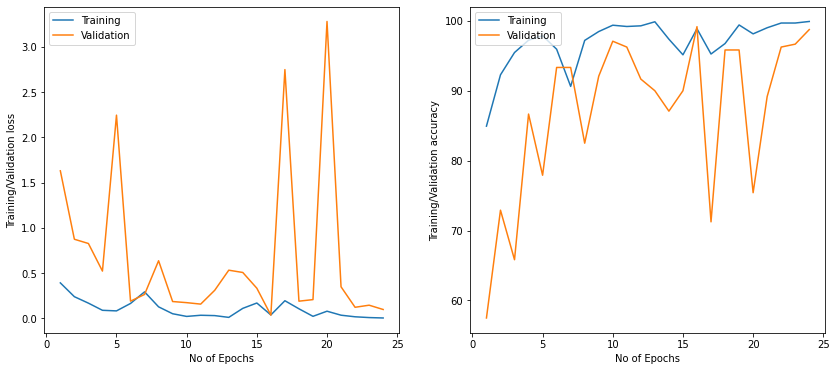

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].plot(range(1,len(train_val_metrics_effnet['epoch_train_loss'])+1), train_val_metrics_effnet['epoch_train_loss'], label="Training" )
ax[0].plot(range(1,len(train_val_metrics_effnet['epoch_val_loss'])+1), train_val_metrics_effnet['epoch_val_loss'], label="Validation" )
ax[0].set_xlabel("No of Epochs")
ax[0].set_ylabel("Training/Validation loss")
ax[0].legend(loc="upper left")
ax[1].plot(range(1,len(train_val_metrics_effnet['epoch_train_accuracy'])+1), train_val_metrics_effnet['epoch_train_accuracy'], label="Training" )
ax[1].plot(range(1,len(train_val_metrics_effnet['epoch_val_accuracy'])+1), train_val_metrics_effnet['epoch_val_accuracy'], label="Validation")
ax[1].set_xlabel("No of Epochs")
ax[1].set_ylabel("Training/Validation accuracy")
ax[1].legend(loc="upper left")

##### Step 6: Evaluate the best model on test data
Evaluate the performance of best model saved on Test dataset images.

In [29]:
# Load the best model saved during the training process
best_model_efficient_net = efficient_net_7_Model()
checkpoint = torch.load("outputs/best_model_eff_net_model_7.pth")

# Load the state dict vlaues
best_model_efficient_net.load_state_dict(checkpoint['model_state_dict'])
### now you can evaluate it
best_model_efficient_net.eval()


labels_test = []
predicted_lbl_test = []
accuracy_lst = []

# Predict for Test Dataset 
for i, (images, labels) in enumerate(test_loader):
    
    # Predict the labels
    predicted_values = best_model_efficient_net(images)
    labels_test.extend(labels)
    # Calculate accuracy
    accuracy, pred_labels  = binary_acc(predicted_values, labels )
    accuracy = accuracy.item()
    predicted_lbl_test.extend(pred_labels)

    accuracy_lst.append(accuracy)
    
print( "Accuracy on Test Dataset ", np.round(np.average(accuracy_lst), 3))
print(classification_report(labels_test, [ lbl.item() for lbl in predicted_lbl_test ]))

Loaded pretrained weights for efficientnet-b7
Accuracy on Test Dataset  98.325
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       290
           1       0.98      0.99      0.98       307

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



The accuracy of the EfficientNet model looks good on Test Data images.

----------------------------------------------------------------------------------------------

<html>
    <div align="left"><img src="Results.gif" width="200" height="200" align="left">
    </div>
     <div >
         <h3><br><br>Results </h3>
    </div>
</html>

The EfficientNet model with pretrained layers works best for out dataset. We are able to 98.8% accuracy in classifying Test images. 

----------------------------------------------------------------------------------------------

<div align="left"> <img src="Summary.png" width="300" height="300" align="left"> </div>

In the project we have explored Custom CNN network and pretrained Efficient network with custom classification layer for binary classification. The summary of the trained model looks like 

|  | Model Name  | Accuracy Test Data   | F1-Score Test Data   | Best Accuracy Validation Images | Training Images Accuracy  |
|---|---|---|---|---|---|
| 1 | Custom CNN  | 76.549% | 0.76   |   76.6%   |  98.3%    |
| 2 | EfficientNet Pre-Trained  |98.32%    | 0.98   | 99.1%    | 98.9% |

The EfficientNet Pre-Trained Network seems to have performed really good for our dataset, thereby proving the efficiency and scalability of EfficientNet networks for Classification problems.